The UPOS field contains a part-of-speech tag from the universal POS tag set, while the XPOS optionally contains a language-specific (or even treebank-specific) part-of-speech / morphological tag

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import pickle_load
from process_conllu import ConlluDataset

In [2]:
def merge_word_hidden_pos(viterbi_pos: list[list[str]], true_pos: list[list[str]], obs_seqs: list[list[str]]):
    merged_pos = []
    for seq_idx, (pred_hidden_seq, true_hidden_seq, obs_seq) in enumerate(zip(
        viterbi_pos, true_pos, obs_seqs)):
        for hidden_state, pos, obs_state in zip(pred_hidden_seq, true_hidden_seq, obs_seq):
            merged_pos.append((seq_idx, hidden_state, pos, obs_state))
    return pd.DataFrame(merged_pos, columns=["sentence", "hidden state", "pos", "token"])

In [3]:
def pos_viterbi_bert_count(viterbi_pos_df: pd.DataFrame, k_means_pos_df: pd.DataFrame):
    assert len(viterbi_pos_df) == len(k_means_pos_df)
    df = viterbi_pos_df["pos"].groupby(viterbi_pos_df["pos"]).size().to_frame()
    df = df.rename(columns={"pos": "pos count"}).reset_index()
    df["pos %"] = df["pos count"] / sum(df["pos count"])
    df = df.sort_values("pos count", ascending=False).reset_index(drop=True)
    df["hidden state count"] = viterbi_pos_df["hidden state"]\
      .groupby(viterbi_pos_df["hidden state"]).size().sort_values(ascending=False).reset_index(drop=True)
    df["hidden state %"] = df["hidden state count"] / sum(df["hidden state count"])
    df["bert cluster count"] = k_means_pos_df["cluster"]\
      .groupby(k_means_pos_df["cluster"]).size().sort_values(ascending=False).reset_index(drop=True)
    df["bert cluster %"] = df["bert cluster count"] / sum(df["bert cluster count"])
    return df

In [4]:
def pos_viterbi_bert_word(viterbi_pos_df: pd.DataFrame, k_means_pos_df: pd.DataFrame):
    pos_to_token = viterbi_pos_df[["pos", "token"]]\
      .groupby("token")\
      .agg(count=("token", "count"),
          pos=("pos", frozenset))\
      .reset_index()
    pos_to_token["pos"] = pos_to_token["pos"].apply(sorted)
    pos_to_token.set_index("token", inplace=True)

    pos_hidden_state_to_token = viterbi_pos_df[["hidden state", "token"]]\
      .groupby("token")\
      .agg(count=("token", "count"),
          hidden_states=("hidden state", frozenset))\
      .reset_index()
    pos_hidden_state_to_token["hidden_states"] = pos_hidden_state_to_token["hidden_states"].apply(sorted)
    pos_hidden_state_to_token.set_index("token", inplace=True)

    pos_clusters_to_token = k_means_pos_df.rename(columns={"word": "token"})[["cluster", "token"]]\
      .groupby("token")\
      .agg(count=("token", "count"),
          clusters=("cluster", frozenset))\
      .reset_index()
    pos_clusters_to_token["clusters"] = pos_clusters_to_token["clusters"].apply(sorted)
    pos_clusters_to_token.set_index("token", inplace=True)

    pos_to_token["hidden states"] = pos_hidden_state_to_token["hidden_states"]
    pos_to_token["bert clusters"] = pos_clusters_to_token["clusters"]
    return pos_to_token

In [5]:
hmm_upos_1_df = pd.read_csv("results/eval_hmm_upos_1.csv")
hmm_xpos_1_df = pd.read_csv("results/eval_hmm_xpos_1.csv")
hmm_upos_17_df = pd.read_csv("results/eval_hmm_upos_17.csv")
hmm_xpos_17_df = pd.read_csv("results/eval_hmm_xpos_17.csv")
bert_upos_df = pd.read_csv("results/eval_bert_upos.csv")
bert_xpos_df = pd.read_csv("results/eval_bert_xpos.csv")
dataset: ConlluDataset = pickle_load("checkpoints/dataset.pkl")
viterbi_upos: list[list[int]] = pickle_load("results/viterbi_upos_17.pkl")
viterbi_xpos: list[list[int]] = pickle_load("results/viterbi_xpos_17.pkl")
k_means_upos_df = pd.read_csv("results/k_means_upos.csv")
k_means_xpos_df = pd.read_csv("results/k_means_xpos.csv")
# select best seed from v measure
k_means_upos_df = k_means_upos_df[k_means_upos_df["seed"] == 4]
k_means_xpos_df = k_means_xpos_df[k_means_xpos_df["seed"] == 0]

In [6]:
viterbi_upos_df = merge_word_hidden_pos(viterbi_upos, dataset.upos, dataset.sequences)
viterbi_xpos_df = merge_word_hidden_pos(viterbi_xpos, dataset.xpos, dataset.sequences)

In [45]:
upos_counts_df = pos_viterbi_bert_count(viterbi_upos_df, k_means_upos_df)
upos_counts_df

,pos,pos count,pos %,hidden state count,hidden state %,bert cluster count,bert cluster %
0,NOUN,187038,0.196944,127752,0.134518,114299,0.120353
1,PUNCT,109665,0.115473,126904,0.133625,112592,0.118555
2,VERB,106962,0.112627,105517,0.111105,96619,0.101736
3,ADP,97030,0.102169,87794,0.092444,84631,0.089113
4,PROPN,93985,0.098963,81795,0.086127,76356,0.080400
5,DET,80892,0.085176,61409,0.064661,60241,0.063432
6,ADJ,66381,0.069897,58129,0.061208,55932,0.058894
7,NUM,36565,0.038502,54054,0.056917,55909,0.058870
8,PRON,35590,0.037475,42332,0.044574,51939,0.054690
9,ADV,31210,0.032863,39416,0.041504,47660,0.050184


In [8]:
print(f"UPOS POS standard deviation: {upos_counts_df['pos count'].std()}")
print(f"UPOS hidden state standard deviation: {upos_counts_df['hidden state count'].std()}")
print(f"UPOS bert cluster standard deviation: {upos_counts_df['bert cluster count'].std()}")

UPOS POS standard deviation: 50341.13474154289
UPOS hidden state standard deviation: 37475.316535570135
UPOS bert cluster standard deviation: 32059.7777782563


In [9]:
xpos_counts_df = pos_viterbi_bert_count(viterbi_xpos_df, k_means_xpos_df)
xpos_counts_df

,pos,pos count,pos %,hidden state count,hidden state %,bert cluster count,bert cluster %
0,NN,132906,0.139945,73812,0.077721,56962,0.059979
1,IN,98554,0.103774,65868,0.069357,49338,0.051951
2,NNP,91326,0.096163,57115,0.060140,46939,0.049425
3,DT,81841,0.086176,55971,0.058935,44277,0.046622
4,JJ,61196,0.064437,54511,0.057398,40535,0.042682
5,NNS,59811,0.062979,48647,0.051223,38589,0.040633
6,",",48727,0.051308,43371,0.045668,36903,0.038857
7,.,39478,0.041569,41457,0.043653,36884,0.038837
8,CD,36565,0.038502,36451,0.038382,35710,0.037601
9,RB,30968,0.032608,25474,0.026823,33430,0.035201


In [10]:
print(f"XPOS POS standard deviation: {xpos_counts_df['pos count'].std()}")
print(f"XPOS hidden state standard deviation: {xpos_counts_df['hidden state count'].std()}")
print(f"XPOS bert cluster standard deviation: {xpos_counts_df['bert cluster count'].std()}")

XPOS POS standard deviation: 30384.743671484517
XPOS hidden state standard deviation: 17874.711998442737
XPOS bert cluster standard deviation: 13329.003228776233


In [46]:
upos_to_token = pos_viterbi_bert_word(viterbi_upos_df, k_means_upos_df)
upos_to_token.sort_values("count", ascending=False).head(20)

,count,pos,hidden states,bert clusters
token,,,,
",",48723,[PUNCT],"[9, 10, 12]","[0, 2, 3, 6, 7, 8, 10, 12, 13, 16]"
the,47975,"[ADJ, DET, NOUN, PROPN, VERB]","[0, 4]","[2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 16]"
.,39020,[PUNCT],"[9, 12]","[3, 5, 6, 7, 8, 9, 12, 13, 14, 16]"
[NUM],23927,"[NUM, PROPN, PUNCT, VERB, X]","[0, 4, 6, 7, 9, 10]",NaN
of,23005,"[ADP, ADV, SCONJ]","[5, 12]","[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]"
to,22352,"[ADP, PART]","[0, 5, 11, 13]","[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 16]"
a,20149,"[DET, NOUN, PROPN, SYM, X]","[0, 4, 8, 12, 13]","[2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 16]"
in,16931,"[ADP, ADV, PROPN, SCONJ, X]","[5, 7, 12, 13, 14, 16]","[1, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 16]"
and,16668,"[CONJ, PROPN]","[1, 2, 3, 5, 7, 9, 10, 11, 12, 13, 15]","[0, 3, 4, 7, 8, 9, 10, 12, 13, 14, 16]"


In [58]:
print(f"max no. of UPOS for a word: {max([len(s) for s in upos_to_token['pos']])}")
print(f"max no. of hidden states for a word: {max([len(s) for s in upos_to_token['hidden states']])}")
print(f"max no. of bert clusters for a word: {max([len(s) if type(s) == list else 0 for s in upos_to_token['bert clusters']])}")

max no. of UPOS for a word: 7
max no. of hidden states for a word: 12
max no. of bert clusters for a word: 14


In [71]:
viterbi_upos_df = viterbi_upos_df.dropna(subset=["token"])
upos_hmm_meaning_df = viterbi_upos_df[viterbi_upos_df["token"].str.contains("finan")][["token", "hidden state"]].groupby("token")\
    .agg(count=("token", "count"),
        hidden_states=("hidden state", frozenset))\
    .sort_values("count", ascending=False)\
    .reset_index()
upos_hmm_meaning_df["hidden_states"] = upos_hmm_meaning_df["hidden_states"].apply(sorted)
upos_hmm_meaning_df

,token,count,hidden_states
0,financial,592,"[1, 4, 6, 8, 10]"
1,financing,185,"[3, 4, 6, 7, 9, 10, 16]"
2,finance,169,"[6, 7, 10, 16]"
3,financier,24,"[4, 5, 6, 10]"
4,financially,23,"[3, 4, 6, 7, 10, 13]"
5,refinancing,21,"[4, 6, 8, 9, 10, 12, 14, 16]"
6,financed,18,"[7, 16]"
7,financial-services,16,"[4, 7, 10]"
8,finances,14,"[6, 7, 10]"
9,financiere,11,"[4, 6, 7]"


In [60]:
k_means_upos_df = k_means_upos_df.dropna(subset=["word"])
upos_bert_meaning_df = k_means_upos_df[k_means_upos_df["word"].str.contains("finan")][["word", "cluster"]].groupby("word")\
    .agg(count=("word", "count"),
        clusters=("cluster", frozenset))\
    .sort_values("count", ascending=False)\
    .reset_index()
upos_bert_meaning_df["clusters"] = upos_bert_meaning_df["clusters"].apply(sorted)
upos_bert_meaning_df

,word,count,clusters
0,financial,465,[11]
1,financing,175,"[4, 11]"
2,finance,132,"[4, 11]"
3,financier,24,[11]
4,financially,23,[11]
5,refinancing,21,"[4, 9, 11]"
6,financed,18,"[4, 11]"
7,financial-services,16,"[9, 11, 12]"
8,finances,13,"[7, 11]"
9,financiers,7,"[9, 11, 12]"


In [16]:
xpos_to_token = pos_viterbi_bert_word(viterbi_xpos_df, k_means_xpos_df)
xpos_to_token.sort_values("count", ascending=False).head(20)

,count,pos,hidden states,bert clusters
token,,,,
",",48723,"[,]","[2, 9, 14, 19, 20, 32, 39]","[3, 4, 5, 7, 11, 12, 13, 16, 18, 21, 22, 23, 2..."
the,47975,"[DT, JJ, NN, NNP, VB, VBP]","[21, 32, 38]","[0, 3, 4, 5, 7, 11, 13, 18, 19, 23, 24, 25, 26..."
.,39020,[.],"[32, 39]","[3, 5, 7, 11, 14, 15, 22, 24, 25, 27, 32, 35, 39]"
[NUM],23927,"[,, CD, LS, NNP, VBN]","[1, 2, 7, 10, 15, 24, 28, 30, 31, 39, 42]",NaN
of,23005,"[IN, RB, RP]","[1, 2, 3, 5, 9, 32, 33]","[3, 4, 5, 6, 7, 11, 13, 18, 19, 20, 21, 23, 24..."
to,22352,[TO],"[2, 3, 9, 14, 20, 24, 30, 32, 34, 38, 42]","[4, 5, 6, 7, 12, 13, 19, 22, 23, 24, 25, 26, 2..."
a,20149,"[DT, FW, LS, NN, NNP, SYM]","[2, 16, 19, 21, 23, 24, 27, 31, 32, 36, 38]","[0, 2, 4, 5, 7, 13, 18, 20, 22, 24, 25, 26, 33..."
in,16931,"[FW, IN, NNP, RB, RBR, RP]","[2, 3, 9, 12, 18, 20, 21, 32, 38]","[4, 5, 6, 7, 11, 13, 19, 20, 22, 23, 24, 25, 2..."
and,16668,"[CC, NNP]","[1, 2, 4, 5, 9, 13, 14, 16, 17, 18, 19, 22, 24...","[2, 5, 6, 7, 11, 12, 13, 23, 24, 25, 29, 31, 3..."


In [59]:
print(f"max no. of XPOS for a word: {max([len(s) for s in xpos_to_token['pos']])}")
print(f"max no. of hidden states for a word: {max([len(s) for s in xpos_to_token['hidden states']])}")
print(f"max no. of bert clusters for a word: {max([len(s) if type(s) == list else 0 for s in xpos_to_token['bert clusters']])}")

max no. of XPOS for a word: 8
max no. of hidden states for a word: 25
max no. of bert clusters for a word: 27


In [72]:
viterbi_xpos_df = viterbi_xpos_df.dropna(subset=["token"])
xpos_hmm_meaning_df = viterbi_xpos_df[viterbi_xpos_df["token"].str.contains("finan")][["token", "hidden state"]].groupby("token")\
    .agg(count=("token", "count"),
        hidden_states=("hidden state", frozenset))\
    .sort_values("count", ascending=False)\
    .reset_index()
xpos_hmm_meaning_df["hidden_states"] = xpos_hmm_meaning_df["hidden_states"].apply(sorted)
xpos_hmm_meaning_df

,token,count,hidden_states
0,financial,592,"[0, 3, 7, 10, 17, 23, 25, 28, 30, 36, 40, 42]"
1,financing,185,"[7, 10, 12, 13, 17, 19, 23, 26, 27, 36, 41]"
2,finance,169,"[7, 10, 17, 20, 35, 36, 42]"
3,financier,24,"[0, 2, 10, 35, 36]"
4,financially,23,"[4, 6, 10, 15, 21, 24, 27, 42]"
5,refinancing,21,"[7, 18, 20, 23, 36, 41, 42]"
6,financed,18,"[13, 27]"
7,financial-services,16,"[7, 10, 17, 42]"
8,finances,14,"[7, 10, 27, 36]"
9,financiere,11,"[7, 10, 22]"


In [61]:
k_means_xpos_df = k_means_xpos_df.dropna(subset=["word"])
xpos_meaning_df = k_means_xpos_df[k_means_xpos_df["word"].str.contains("finan")][["word", "cluster"]].groupby("word")\
    .agg(count=("word", "count"),
        clusters=("cluster", frozenset))\
    .sort_values("count", ascending=False)\
    .reset_index()
xpos_meaning_df["clusters"] = xpos_meaning_df["clusters"].apply(sorted)
xpos_meaning_df

,word,count,clusters
0,financial,465,"[37, 43]"
1,financing,175,"[31, 37, 43]"
2,finance,132,"[31, 37, 43]"
3,financier,24,[43]
4,financially,23,[37]
5,refinancing,21,"[23, 31, 37]"
6,financed,18,[37]
7,financial-services,16,"[11, 23, 43]"
8,finances,13,"[37, 43]"
9,financiers,7,"[23, 43]"


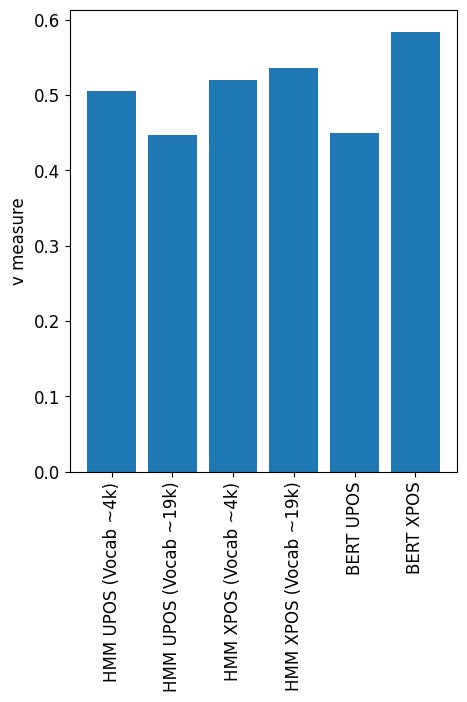

In [35]:
labels = ["HMM UPOS (Vocab ~4k)", "HMM UPOS (Vocab ~19k)", "HMM XPOS (Vocab ~4k)", "HMM XPOS (Vocab ~19k)", "BERT UPOS", "BERT XPOS"]
values = [0.5054494292354509, 0.4472084912917285, 0.5200655036661923, 0.5359719426401087, 0.45004099364287065, 0.584324063148953]
fig, ax = plt.subplots()
ax.bar(labels, values, label=labels)
ax.set_ylabel("v measure")
plt.xticks(rotation=90)
fig.set_size_inches(5, 6)
plt.show()

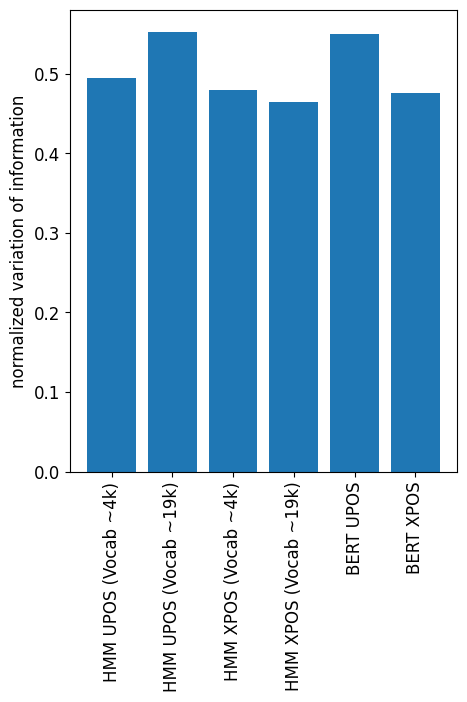

In [34]:
labels = ["HMM UPOS (Vocab ~4k)", "HMM UPOS (Vocab ~19k)", "HMM XPOS (Vocab ~4k)", "HMM XPOS (Vocab ~19k)", "BERT UPOS", "BERT XPOS"]
values = [0.494550570764549, 0.5527915087082714, 0.4799344963338071, 0.4640280573598915, 0.5499590063571296, 0.4761732308055556]
fig, ax = plt.subplots()
ax.bar(labels, values, label=labels)
ax.set_ylabel("normalized variation of information")
plt.xticks(rotation=90)
fig.set_size_inches(5, 6)
plt.show()

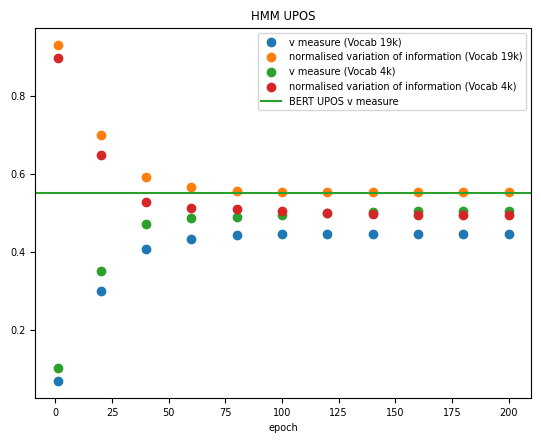

In [23]:
fig, ax = plt.subplots()
ax.scatter(hmm_upos_1_df["epoch"], hmm_upos_1_df["v measure"], label="v measure (Vocab 19k)")
ax.scatter(hmm_upos_1_df["epoch"], hmm_upos_1_df["normalised voi"], label="normalised variation of information (Vocab 19k)")
ax.scatter(hmm_upos_17_df["epoch"], hmm_upos_17_df["v measure"], label="v measure (Vocab 4k)")
ax.scatter(hmm_upos_17_df["epoch"], hmm_upos_17_df["normalised voi"], label="normalised variation of information (Vocab 4k)")
ax.axhline(y = 0.550, color="tab:green", label="BERT UPOS v measure")
ax.set_title("HMM UPOS")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

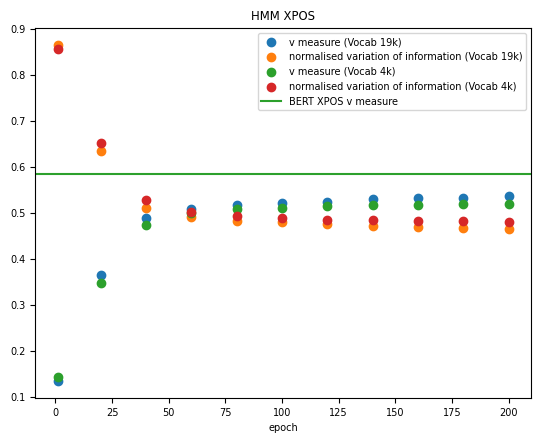

In [24]:
fig, ax = plt.subplots()
ax.scatter(hmm_xpos_1_df["epoch"], hmm_xpos_1_df["v measure"], label="v measure (Vocab 19k)")
ax.scatter(hmm_xpos_1_df["epoch"], hmm_xpos_1_df["normalised voi"], label="normalised variation of information (Vocab 19k)")
ax.scatter(hmm_xpos_17_df["epoch"], hmm_xpos_17_df["v measure"], label="v measure (Vocab 4k)")
ax.scatter(hmm_xpos_17_df["epoch"], hmm_xpos_17_df["normalised voi"], label="normalised variation of information (Vocab 4k)")
ax.axhline(y = 0.584, color="tab:green", label="BERT XPOS v measure")
ax.set_title("HMM XPOS")
ax.set_xlabel("epoch")
ax.legend()
plt.show()